<a class="anchor" id="top"></a>
# Formation Data Analyst - Projet 6 - Détéctez les faux billets

Antoine LEPAGE <br /> 
yop1001@gmail.com

https://openclassrooms.com/projects/detectez-des-faux-billets

## Table des matières


1. [Contexte](#contexte)<br /> 
<br /> 
2. [Construction de l'échantillon](#echantillon)<br /> 
    2.1. [Chargement des données](#echantillon)<br />
    2.2. [Description des données](#description)<br />
<br />
3. [ACP](#acp)<br /> 
    3.1. [Eboulis des valeurs propres](#acp)<br />
    3.2. [Cercle des corrélations](#cercle_des_correlations)<br />
    3.3. [Représentation des individus par les plans factoriels](#representation)<br />
    3.4. [Analyse qualité de représentation et contribution des individus](#analyse)<br />
    3.5. [Contribution des individus aux axes](#contribution)<br />
<br />
4. [Classification - Méthode des centres mobiles - KMeans](#kmeans)<br /> 
    4.1. [Détection du nombre adéquat de groupes](#kmeans)<br />
    4.2. [Application de l'algorithme K-means](#algo)<br />
    4.3. [Visualisation des groupes sur le plan factoriel de l'ACP](#visualisation)<br />
<br />
5. [Regression logistique](#regression)<br /> 
    5.1. [5.1 Modèle](#regression)<br />
    5.2. [5.2 Evaluation du modèle](#evaluation)<br /> 
    5.3. [5.3 Prédiction de l'authenticité à partir de nouveaux billets](#prediction)<br />  
   

<a class="anchor" id="contexte"></a>
## 1. Contexte 

Votre société de consulting informatique vous propose une nouvelle mission au ministère de l'intérieur, dans le cadre de la lutte contre la criminalité organisée, à l'office central pour la répression du faux monnayage . Votre mission si vous l'acceptez : créer un algorithme de détection de faux billets.

<a class="anchor" id="echantillon"></a>
***
## 2. Construction de l'échantillon

### 2.1 Chargement données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

#import matplotlib.pyplot as plt
#import scipy.stats as st
#%matplotlib inline
#from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, centroid
#from scipy.cluster import hierarchy

In [2]:
# Importer les fichers sources
data = pd.read_csv('00 - Sources/billets.csv', sep=',')
data.tail()

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87
169,False,171.96,104.00,103.95,5.63,3.26,110.96


In [3]:
data.shape

(170, 7)

In [4]:
# Vérifions s'il y a des valeurs manquants
data.isnull().sum()

is_genuine      0
length          0
height_left     0
height_right    0
margin_low      0
margin_up       0
diagonal        0
dtype: int64

<a class="anchor" id="description"></a>
***
### 2.2 Description des données

In [5]:
data.describe()

,length,height_left,height_right,margin_low,margin_up,diagonal
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
is_genuine      170 non-null bool
length          170 non-null float64
height_left     170 non-null float64
height_right    170 non-null float64
margin_low      170 non-null float64
margin_up       170 non-null float64
diagonal        170 non-null float64
dtypes: bool(1), float64(6)
memory usage: 8.2 KB


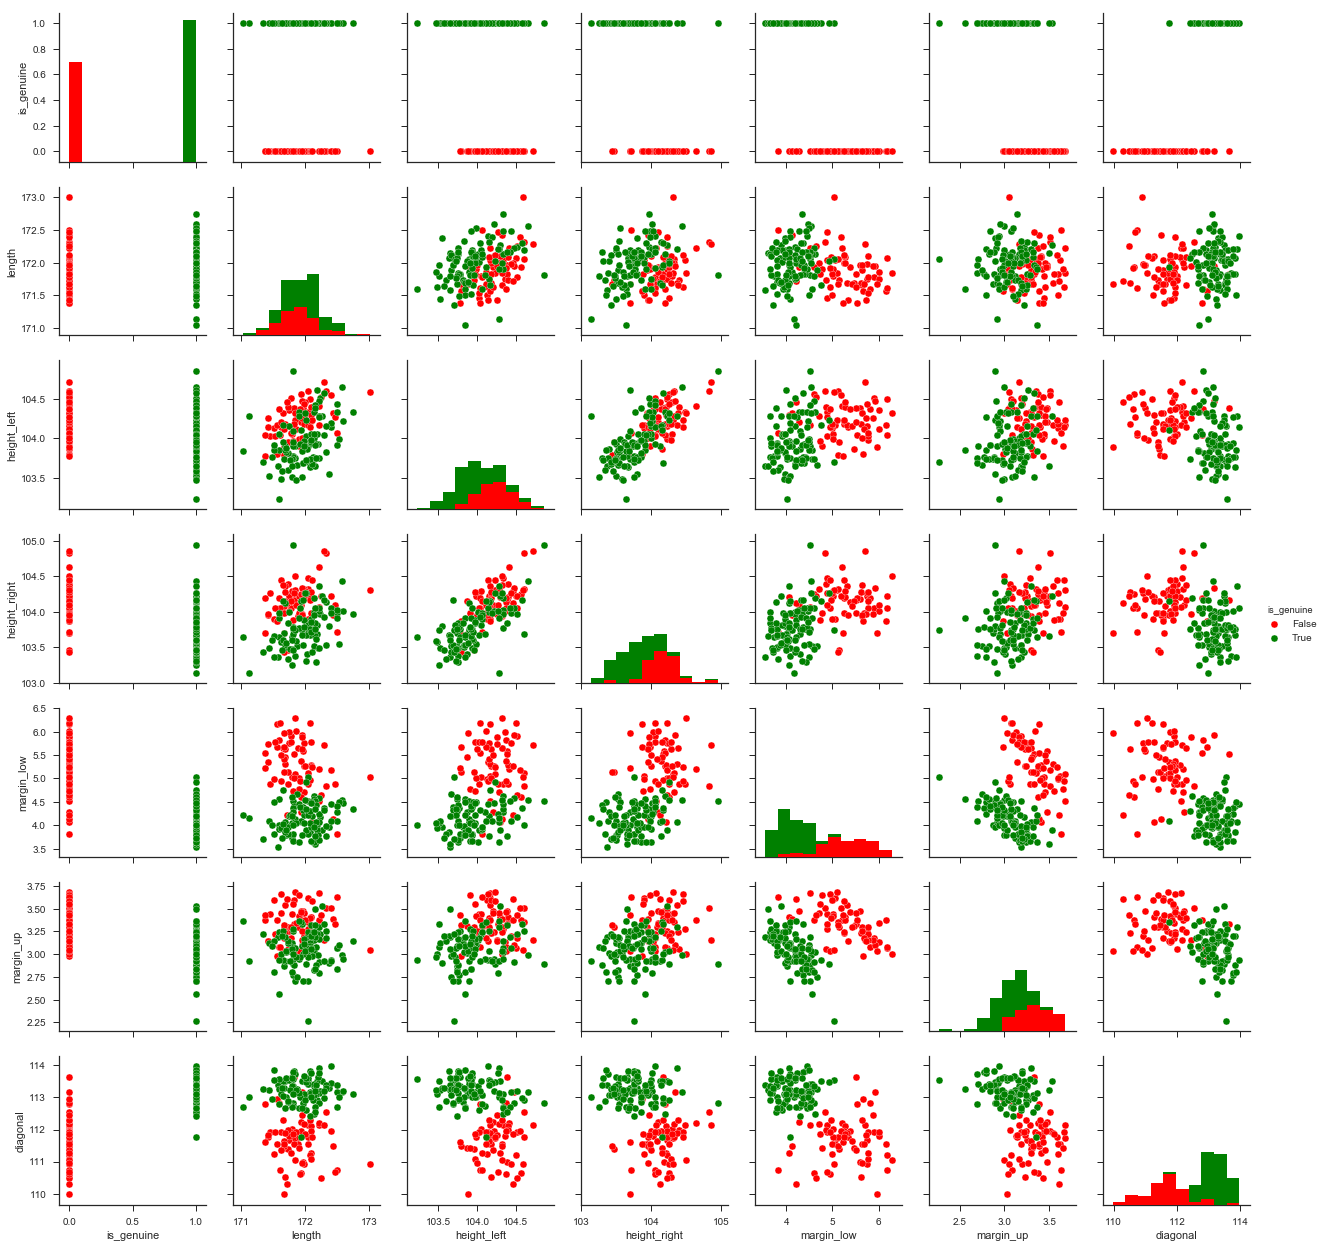

In [7]:
sns.set(style="ticks")
sns.pairplot(data, hue="is_genuine", palette=["r", "g"])

plt.savefig('01 - Graphs/01 - Pairplot.png', bbox_inches='tight', dpi=100)

In [8]:
# Matrice des corrélations

data_num = data.iloc[:, 1:]

corr = data_num.corr()
corr.style.background_gradient()

,length,height_left,height_right,margin_low,margin_up,diagonal
length,1,0.319584,0.220418,-0.18102,-0.0273655,0.0802952
height_left,0.319584,1,0.73439,0.42453,0.324788,-0.421387
height_right,0.220418,0.73439,1,0.509375,0.366918,-0.417021
margin_low,-0.18102,0.42453,0.509375,1,0.171113,-0.637352
margin_up,-0.0273655,0.324788,0.366918,0.171113,1,-0.525284
diagonal,0.0802952,-0.421387,-0.417021,-0.637352,-0.525284,1


In [9]:
# ANOVA - Analyse des Variances - Calcul de eta carré 
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT
    
eta_squared(data["is_genuine"],data["diagonal"])

0.6818507654957807

In [10]:
eta_squared(data["is_genuine"],data["length"])

0.019383108567093802

In [11]:
eta_squared(data["is_genuine"],data["height_left"])

0.21319458315018705

In [12]:
eta_squared(data["is_genuine"],data["height_right"])

0.30394154672012125

In [13]:
eta_squared(data["is_genuine"],data["margin_low"])

0.640177214288775

In [14]:
eta_squared(data["is_genuine"],data["margin_up"])

0.3396567096032002

In [15]:
# Séparons les billets selon leur authenticité :
billets_v = data[data['is_genuine'] == True]
billets_f = data[data['is_genuine'] == False]

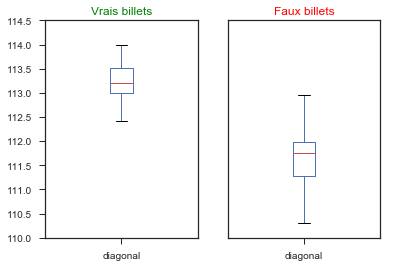

In [16]:
# Répartition des valeurs des diagonales des billets selon leur authenticité
plt.subplot(1,2,1)
billets_v['diagonal'].plot(kind='box')
plt.ylim(110,114.5)
plt.title('Vrais billets', color='g')

plt.subplot(1,2,2)
billets_f['diagonal'].plot(kind='box')
plt.ylim(110,114.5)
plt.yticks([]) # pour cacher 
plt.title('Faux billets', color='r')

plt.savefig('01 - Graphs/02 - diagonal.png', bbox_inches='tight', dpi=100)

plt.show()

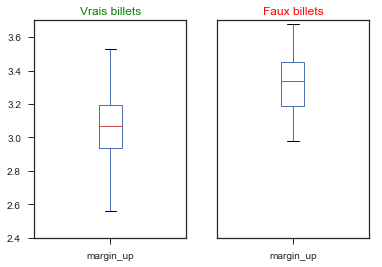

In [17]:
# Répartition des valeurs des marges supérieures des billets selon leur authenticité
plt.subplot(1,2,1)
billets_v['margin_up'].plot(kind='box')
plt.ylim(2.4, 3.7)
plt.title('Vrais billets', color='g')

plt.subplot(1,2,2)
billets_f['margin_up'].plot(kind='box')
plt.ylim(2.4, 3.7)
plt.yticks([]) # pour cacher 
plt.title('Faux billets', color='r')

plt.savefig('01 - Graphs/03 - Margin_up.png', bbox_inches='tight', dpi=100)

plt.show()

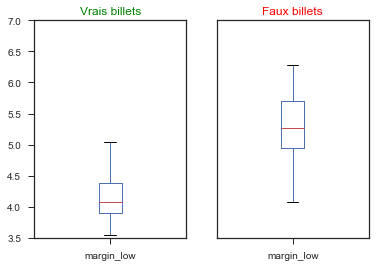

In [18]:
# Répartition des valeurs des marges inférieures des billets selon leur authenticité
plt.subplot(1,2,1)
billets_v['margin_low'].plot(kind='box')
plt.ylim(3.5, 7)
plt.title('Vrais billets', color='g')

plt.subplot(1,2,2)
billets_f['margin_low'].plot(kind='box')
plt.ylim(3.5, 7)
plt.yticks([]) # pour cacher 
plt.title('Faux billets', color='r')

plt.savefig('01 - Graphs/04 - Margin_low.png', bbox_inches='tight', dpi=100)

plt.show()

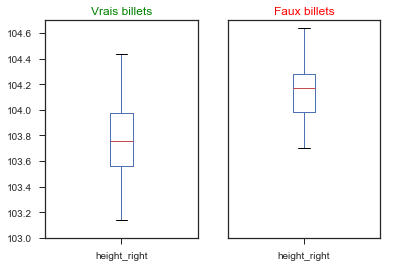

In [19]:
# Répartition des valeurs des hauteurs droite des billets selon leur authenticité
plt.subplot(1,2,1)
billets_v['height_right'].plot(kind='box')
plt.ylim(103, 104.7)
plt.title('Vrais billets', color='g')

plt.subplot(1,2,2)
billets_f['height_right'].plot(kind='box')
plt.ylim(103, 104.7)
plt.yticks([]) # pour cacher 
plt.title('Faux billets', color='r')

plt.savefig('01 - Graphs/05 - Height_right.png', bbox_inches='tight', dpi=100)

plt.show()

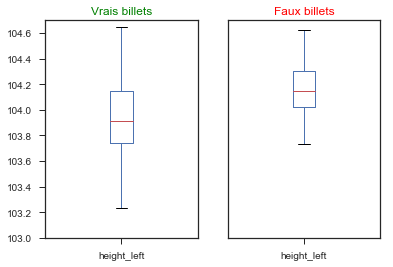

In [20]:
# Répartition des valeurs des hauteurs gauche des billets selon leur authenticité
plt.subplot(1,2,1)
billets_v['height_left'].plot(kind='box')
plt.ylim(103, 104.7)
plt.title('Vrais billets', color='g')

plt.subplot(1,2,2)
billets_f['height_left'].plot(kind='box')
plt.ylim(103, 104.8)
plt.yticks([]) # pour cacher 
plt.title('Faux billets', color='r')

plt.savefig('01 - Graphs/06 - Height_left.png', bbox_inches='tight', dpi=100)

plt.show()

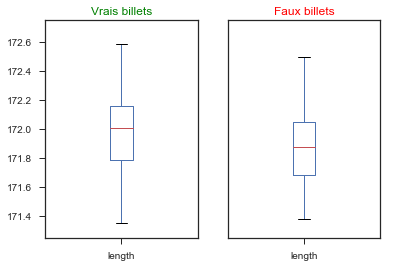

In [21]:
# Répartition des valeurs des longueurs des billets selon leur authenticité
plt.subplot(1,2,1)
billets_v['length'].plot(kind='box')
plt.ylim(171.25, 172.75)
plt.title('Vrais billets', color='g')

plt.subplot(1,2,2)
billets_f['length'].plot(kind='box')
plt.ylim(171.25, 172.75)
plt.yticks([]) # pour cacher 
plt.title('Faux billets', color='r')

plt.savefig('01 - Graphs/07 - Length.png', bbox_inches='tight', dpi=100)

plt.show()

<a class="anchor" id="acp"></a>
***
## 3. ACP

### 3.1 Eboulis des valeurs propres

In [22]:
data_2 = data[['length', 'height_left', 'height_right', 'margin_low', 'margin_up', 'diagonal']]
data_2.head()

,length,height_left,height_right,margin_low,margin_up,diagonal
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55


In [23]:
# Convertir les données en un array numpy
X = data_2.values
print (X.shape)

(170, 6)


In [24]:
# Standardisons les données
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [25]:
# ACP
from sklearn import decomposition

# Création d'un objet ACP - sans spécifier le nombre de composantes
pca = decomposition.PCA()

# On peut également demander à sklearn de choisir le nombre de PCA pour respecter que 95% (exemple) dela variance soit expliquee
# pca =PCA(0.95)

# Appliquer l'objet PCA aux données normalisées
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [26]:
# Calcul de la fraction de la variance est expliquee
print(pca.explained_variance_ratio_)

[0.47447921 0.21957106 0.14234524 0.08526295 0.04612822 0.03221331]


In [27]:
# Si on veut la somme cumulative
print(pca.explained_variance_ratio_.cumsum())

[0.47447921 0.69405027 0.83639551 0.92165846 0.96778669 1.        ]


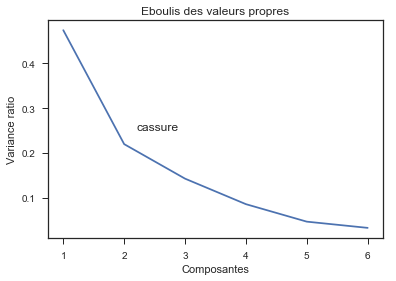

In [28]:
# Scree plot ou éboulis des valeurs propres
# source : http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_ACP_Python.pdf
# np.arrange permet de commencer la numérotation à 1

plt.plot(np.arange(1,7), pca.explained_variance_ratio_)

plt.title("Eboulis des valeurs propres")
plt.ylabel("Variance ratio")
plt.xlabel("Composantes")
plt.text(2.2, 0.25, 'cassure')

plt.savefig('01 - Graphs/08 - Ebouli.png')
plt.show()


On va choisir une représentation dans 2 plans factoriels

<a class="anchor" id="cercle_des_correlations"></a>
***
### 3.2 Cercle des corrélations

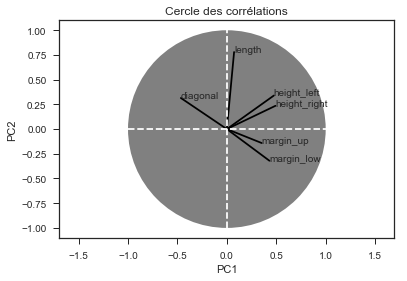

In [29]:
# Cercle des correlations
# Visualisation de la contribution de chaque variable à chaque composante
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data_subset.columns[i]) de la performance
    plt.text(x, y, data_2.columns[i], fontsize='10')
    
# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='white', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1, 1], color='white', ls='--')


#draw circle
centre_circle = plt.Circle((0,0),1,fc='grey')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title("Cercle des corrélations")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.axis('equal')


plt.savefig('01 - Graphs/09 - Cercle_corr.png')
plt.show()

<a class="anchor" id="representation"></a>
***
### 3.3 Représentation des individus par les plans factoriels

In [30]:
# Visualisation en 2D

# Création d'un objet ACP avec 2 composantes
pca = decomposition.PCA(n_components=2)

# Appliquer l'objet PCA aux données normalisées
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [31]:
# projeter les données initiales sur les 2 axes
X_projected = pca.transform(X_scaled)
print(X_projected.shape)

(170, 2)


In [32]:
X_projected

array([[ 2.15363875,  1.59970945],
       [-2.11041589, -0.52603892],
       [-1.97315242, -0.04810178],
       [-2.05979509, -0.08910521],
       [-2.40318009,  0.41216977],
       [ 1.23565611,  2.98319112],
       [-2.07941191,  1.14797998],
       [-2.62393408, -1.04013317],
       [-1.73630901, -0.227631  ],
       [ 0.72748966,  1.06388107],
       [ 0.49582635,  1.73847781],
       [-2.09026468,  0.41670968],
       [ 0.16022666,  1.43072514],
       [-1.51099968, -0.16606   ],
       [-1.24242842,  0.60216942],
       [-1.75333312, -0.50267375],
       [-1.21324817,  0.03566659],
       [-1.66473154,  0.57778357],
       [-1.48336646,  0.36363733],
       [-0.75344444,  0.28241819],
       [-1.78026387,  0.04851185],
       [ 0.03144616,  2.37337698],
       [ 0.32912853,  1.68824072],
       [-0.20619611,  2.30300194],
       [-1.22566926,  0.59722119],
       [ 0.23751564,  1.88390247],
       [-0.72903068,  2.07182053],
       [ 0.08123469,  0.96744265],
       [-0.95290722,

In [33]:
data_acp = pd.DataFrame(data=X_projected)
data_acp.head()

,0,1
0,2.153639,1.599709
1,-2.110416,-0.526039
2,-1.973152,-0.048102
3,-2.059795,-0.089105
4,-2.403180,0.412170


In [34]:
data_acp['is_genuine']=data['is_genuine']
data_acp.head()

,0,1,is_genuine
0,2.153639,1.599709,True
1,-2.110416,-0.526039,True
2,-1.973152,-0.048102,True
3,-2.059795,-0.089105,True
4,-2.403180,0.412170,True


In [35]:
data_acp.rename(columns={0:'PC1', 1:'PC2'}, inplace=True)
data_acp.head()

,PC1,PC2,is_genuine
0,2.153639,1.599709,True
1,-2.110416,-0.526039,True
2,-1.973152,-0.048102,True
3,-2.059795,-0.089105,True
4,-2.403180,0.412170,True


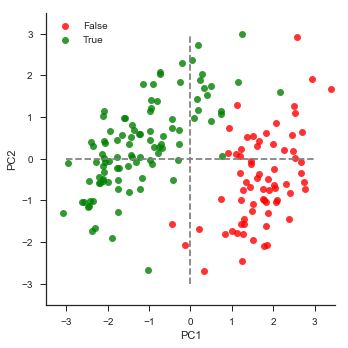

In [36]:
fig = plt.figure(figsize=(10,10))

# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="PC1", y="PC2", data=data_acp, fit_reg=False, hue='is_genuine', legend=False, palette=['r', 'g'])
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper left')
 
# Afficher une ligne horizontale y=0
plt.plot([-3, 3], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-3, 3], color='grey', ls='--')

plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])

plt.savefig('01 - Graphs/10 - ACP.png')

plt.show()

<a class="anchor" id="analyse"></a>
***
### 3.4 Qualité de représentation des individus sur les axes

source: http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_ACP_Python.pdf

COS² permet de quantifier la qualité de la projection au niveau de chaque point (indice de non deformation dezs distances vues sur le plan ACP).

On calcule d'abord les carrés des distances à l’origine des individus, qui correspondent également à leur contribution dans
l’inertie totale

In [37]:
# Qualité de représentation des individus sur les axe

#contribution des individus dans l'inertie totale
di = np.sum(X_projected**2,axis=1)
print(pd.DataFrame({'ID':data.index,'d_i':di}))


      ID        d_i
0      0   7.197230
1      1   4.730572
2      2   3.895644
3      3   4.250696
4      4   5.945158
5      5  10.426275
6      6   5.641812
7      7   7.966907
8      8   3.066585
9      9   1.661084
10    10   3.268149
11    11   4.542853
12    12   2.072647
13    13   2.310696
14    14   1.906236
15    15   3.326858
16    16   1.473243
17    17   3.105165
18    18   2.332608
19    19   0.647439
20    20   3.171693
21    21   5.633907
22    22   2.958482
23    23   5.346335
24    24   1.858938
25    25   3.605502
26    26   4.823926
27    27   0.942544
28    28   2.399293
29    29   8.762839
..   ...        ...
140  140   4.677052
141  141   2.866030
142  142   7.804893
143  143   5.172347
144  144   2.607414
145  145   2.933961
146  146   7.266462
147  147   7.699125
148  148   3.732473
149  149   2.464234
150  150   1.571067
151  151   7.602835
152  152   4.253649
153  153   7.704245
154  154   5.901408
155  155   3.741992
156  156   7.328211
157  157   4.467575


In [38]:
type(di)


numpy.ndarray

In [39]:
# Qualité de réprésentation des individus : COS²

cos2 = X_projected ** 2
for j in range(2):
    cos2[:,j] = cos2[:,j]/di

cos2

array([[6.44436784e-01, 3.55563216e-01],
       [9.41504551e-01, 5.84954492e-02],
       [9.99406059e-01, 5.93940664e-04],
       [9.98132132e-01, 1.86786808e-03],
       [9.71424828e-01, 2.85751716e-02],
       [1.46442136e-01, 8.53557864e-01],
       [7.66412271e-01, 2.33587729e-01],
       [8.64203637e-01, 1.35796363e-01],
       [9.83103069e-01, 1.68969305e-02],
       [3.18611921e-01, 6.81388079e-01],
       [7.52241655e-02, 9.24775834e-01],
       [9.61775796e-01, 3.82242044e-02],
       [1.23863752e-02, 9.87613625e-01],
       [9.88065966e-01, 1.19340339e-02],
       [8.09778043e-01, 1.90221957e-01],
       [9.24048184e-01, 7.59518159e-02],
       [9.99136527e-01, 8.63472735e-04],
       [8.92490783e-01, 1.07509217e-01],
       [9.43311479e-01, 5.66885207e-02],
       [8.76806787e-01, 1.23193213e-01],
       [9.99257999e-01, 7.42000989e-04],
       [1.75519617e-04, 9.99824480e-01],
       [3.66152575e-02, 9.63384743e-01],
       [7.95252018e-03, 9.92047480e-01],
       [8.081307

In [40]:
df = pd.DataFrame(cos2)
df.rename(columns={0:'COS2_1', 1:'COS2_2'}, inplace=True)
df['COS2_sum'] = df['COS2_1']+df['COS2_2']
df.head()

,COS2_1,COS2_2,COS2_sum
0,0.644437,0.355563,1.0
1,0.941505,0.058495,1.0
2,0.999406,0.000594,1.0
3,0.998132,0.001868,1.0
4,0.971425,0.028575,1.0


In [41]:
df.shape

(170, 3)

In [42]:
# Nb d'individus très bien représentés sur l'axe 1 (+ de 0.75)
df[df['COS2_1'] > 0.75].shape

(103, 3)

In [43]:
# Nb d'individus très bien représentés sur l'axe 2 (+ de 0.75)
df[df['COS2_2'] > 0.75].shape

(27, 3)

Interprétation - exemple de l'individu 0
Sur l'axe 1, l'individu 0 a un indice de non déformation de 0.64 et de 0.36 sur l'axe 2 
103 billets sur 170 sont très bien représentés sur l'axe 1 (vs 27 sur l'axe 2)


info :
sert aussi pour analyser la visualisation de l'ACP en 2D. Attention deux points proches d'un autre ne le sont pas forcement avant l'ACP. Il faut voir les valeurs des COS² pour voir s'ils sotn aussi bien représentés sur les memes axes (en proportion)

In [44]:
# En sommant les deux premiers indices on obtient l'indice de non deformation des distances vues sur le plan ACP
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


<a class="anchor" id="contribution"></a>
***
### 3.5 Contribution des individus aux axes

Elles permettent de déterminer les individus qui pèsent le plus dans la définition de chaque facteur.
source : https://www.youtube.com/watch?v=KIQ7vvik8hw&index=5&list=PLGrJ7r50tBfWB8UdeZXyiTx4bggs4YHIX

In [45]:
#contributions aux axes

ctr = X_projected ** 2
for j in range(2):
    ctr[:,j] = ctr[:,j]/170

ctr

array([[2.72832933e-02, 1.50533548e-02],
       [2.61991485e-02, 1.62774673e-03],
       [2.29019440e-02, 1.36104796e-05],
       [2.49573872e-02, 4.67043443e-05],
       [3.39722032e-02, 9.99317194e-04],
       [8.98144723e-03, 5.23495839e-02],
       [2.54350228e-02, 7.75210606e-03],
       [4.05001768e-02, 6.36398238e-03],
       [1.77339351e-02, 3.04799240e-04],
       [3.11318355e-03, 6.65789954e-03],
       [1.44613983e-03, 1.77782653e-02],
       [2.57012144e-02, 1.02145269e-03],
       [1.51015197e-04, 1.20410260e-02],
       [1.34301179e-02, 1.62211318e-04],
       [9.08016686e-03, 2.13298833e-03],
       [1.80833943e-02, 1.48635824e-03],
       [8.65865363e-03, 7.48297268e-06],
       [1.63019477e-02, 1.96372856e-03],
       [1.29433885e-02, 7.77835914e-04],
       [3.33928540e-03, 4.69176680e-04],
       [1.86431731e-02, 1.38435248e-05],
       [5.81683074e-06, 3.31348136e-02],
       [6.37209363e-04, 1.67656278e-02],
       [2.50099030e-04, 3.11989290e-02],
       [8.836853

In [46]:
df1 = pd.DataFrame(ctr)
df1.rename(columns={0:'CTR_1', 1:'CTR_2'}, inplace=True)
df1.head()

,CTR_1,CTR_2
0,0.027283,0.015053
1,0.026199,0.001628
2,0.022902,0.000014
3,0.024957,0.000047
4,0.033972,0.000999


In [47]:
# Affichons les 5 billets qui influent le plus dans la définition du premier facteur de l'ACP
df1.sort_values(by='CTR_1', ascending=False).head()

,CTR_1,CTR_2
122,0.067637,0.016300
49,0.055856,0.009864
29,0.051497,0.000050
112,0.051102,0.021420
158,0.045083,0.003193


In [48]:
# Affichons les 5 billets qui influent le plus dans la définition du second facteur de l'ACP
df1.sort_values(by='CTR_2', ascending=False).head()

,CTR_1,CTR_2
5,0.008981,0.052350
166,0.039317,0.049966
34,0.000208,0.043873
156,0.000602,0.042505
70,0.006254,0.041520


info : vérifier s'il ny a pas de contribution trop importante sinon virer l'individu de l'analyse

<a class="anchor" id="kmeans"></a>
***
## 4. Classification - Méthode des centres mobiles - KMeans

### 4.1 Détection du nombre adéquat de groupes

#### 4.1.1 Méthode 1

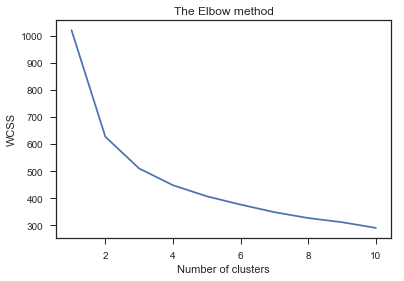

In [49]:
# source : https://www.youtube.com/watch?v=M4DFmMoGpWs

from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0) 
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title("The Elbow method")
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.savefig('01 - Graphs/11 - KMeans_elbow.png')
plt.show()


Conclusion : Effectuer une classification en 2 groupes

<a class="anchor" id="algo"></a>
***
### 4.2 Application de l'algorithme K-means 

In [50]:
#k-means sur les données centrées et réduites
from sklearn import cluster
kmeans = KMeans(n_clusters=2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [51]:
# Affichage des 2 groupes
kmeans.labels_

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [52]:
groupes = kmeans.fit_predict(X_scaled)
groupes

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

<a class="anchor" id="visualisation"></a>
***
### 4.3 Visualisation des groupes sur le plan factoriel de l'ACP

In [53]:
data_acp.head()

,PC1,PC2,is_genuine
0,2.153639,1.599709,True
1,-2.110416,-0.526039,True
2,-1.973152,-0.048102,True
3,-2.059795,-0.089105,True
4,-2.403180,0.412170,True


In [54]:
# Ajoutons cet array aux données initiales
data_acp['Groupe'] = groupes
data_acp.head()

,PC1,PC2,is_genuine,Groupe
0,2.153639,1.599709,True,1
1,-2.110416,-0.526039,True,0
2,-1.973152,-0.048102,True,0
3,-2.059795,-0.089105,True,0
4,-2.403180,0.412170,True,0


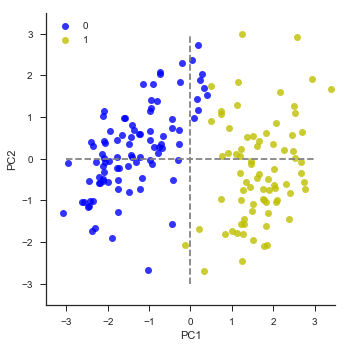

In [55]:
# Visualisation
fig1 = plt.figure(figsize=(10,10))

# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="PC1", y="PC2", data=data_acp, fit_reg=False, hue='Groupe', legend=False, palette=['b', 'y'])
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper left')
 
# Afficher une ligne horizontale y=0
plt.plot([-3, 3], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-3, 3], color='grey', ls='--')

plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5]) 
    
plt.savefig('01 - Graphs/12 - KMeans_ACP.png')

plt.show()

In [56]:
# Quelle est la pertinence de l'algorithme ?
# Source : http://cedric.cnam.fr/vertigo/Cours/ml/tpKmeans.html
from sklearn import metrics

metrics.adjusted_rand_score(kmeans.labels_, data.iloc[:,0])

0.7982443135768854

In [57]:
#correspondance entre les Groupes et l'authenticité des billets
pd.crosstab(data_acp['Groupe'], data_acp['is_genuine'])

is_genuine,False,True
Groupe,,
0,1,92
1,69,8


Conclusion : le groupe 0 issu de la classification K-Means correspond aux brais billets (a 1 pres) et le groupe 1 aux faux billets (a 8 pres)

<a class="anchor" id="regression"></a>
## 5. Regression logistique 

### 5.1 Modèle

Pour une regression linéaire on a pas besoin de standardiser les données : (https://www.youtube.com/watch?v=Q--2Ba1COYU)

In [58]:
data.head()

,is_genuine,length,height_left,height_right,margin_low,margin_up,diagonal
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [59]:
# Définissons les variables indépendantes =(features):
X = data.iloc[:,1:7].values

# Définissons la variable dépendante (=target) :
y = data.iloc[:,0].values

In [60]:
# Regression logistique

from sklearn.linear_model import LogisticRegression

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy
model.score(X, y)

0.9882352941176471

Bon signe très proche de 1

<a class="anchor" id="evaluation"></a>
***
### 5.2 Evaluation du modèle

In [61]:
# Création des training et test set
from sklearn.model_selection  import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=0)

# Verification
print(X.shape)
print(X_train.shape)

(170, 6)
(136, 6)


In [62]:
# Evaluation du modèle en utilisant un set de validation

# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [63]:
# predict class labels for the test set

y_pred = model2.predict(X_test)
print(y_pred)

[False False False  True  True False  True  True False  True False  True
  True False  True  True  True False  True  True False  True False False
 False  True  True False  True  True  True False  True  True False  True
  True False False  True  True False  True False  True False  True False
  True False False]


In [64]:
# generate evaluation metrics

from sklearn import metrics

print(metrics.accuracy_score(y_test, y_pred))


1.0


In [65]:
print( metrics.classification_report(y_test, y_pred))


             precision    recall  f1-score   support

      False       1.00      1.00      1.00        23
       True       1.00      1.00      1.00        28

avg / total       1.00      1.00      1.00        51



In [66]:
# Model evaluation using cross Validation (Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.)

from sklearn.model_selection import cross_val_score

scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[0.94117647 1.         0.94117647 1.         1.         1.
 0.94117647 1.         1.         1.        ]
0.9823529411764707


<a class="anchor" id="prediction"></a>
***
### 5.3 Prédiction de l'authenticité à partir de nouveaux billets

In [78]:
# Importer le fichier à tester
test = pd.read_csv('00 - Sources/exemple.csv', sep=',')
test

,length,height_left,height_right,margin_low,margin_up,diagonal,id
0,171.76,104.01,103.54,5.21,3.30,111.42,B_1
1,171.87,104.17,104.13,6.00,3.31,112.09,B_2
2,172.00,104.58,104.29,4.99,3.39,111.57,B_3
3,172.49,104.55,104.34,4.44,3.03,113.20,B_4
4,171.65,103.63,103.56,3.77,3.16,113.33,B_5


In [79]:
# Mettons l'id en index
test.set_index('id', inplace=True)

In [80]:
# Définissons les variables indépendantes :
X = test.values
X

array([[171.76, 104.01, 103.54,   5.21,   3.3 , 111.42],
       [171.87, 104.17, 104.13,   6.  ,   3.31, 112.09],
       [172.  , 104.58, 104.29,   4.99,   3.39, 111.57],
       [172.49, 104.55, 104.34,   4.44,   3.03, 113.2 ],
       [171.65, 103.63, 103.56,   3.77,   3.16, 113.33]])

In [81]:
# Prédisons l'authenticité des billets
pred = model.predict(X)

In [82]:
# generate class probabilities
probs = model.predict_proba(X)
probs

array([[0.9592519 , 0.0407481 ],
       [0.99054479, 0.00945521],
       [0.97150031, 0.02849969],
       [0.12397597, 0.87602403],
       [0.00374932, 0.99625068]])

In [83]:
# Array to DataFrame

probs = pd.DataFrame(probs)
probs.index = test.index
probs.columns = ['False', 'True']
probs

,False,True
id,,
B_1,0.959252,0.040748
B_2,0.990545,0.009455
B_3,0.971500,0.028500
B_4,0.123976,0.876024
B_5,0.003749,0.996251


In [84]:
test['is_genuine'] = pred
test

,length,height_left,height_right,margin_low,margin_up,diagonal,is_genuine
id,,,,,,,
B_1,171.76,104.01,103.54,5.21,3.30,111.42,False
B_2,171.87,104.17,104.13,6.00,3.31,112.09,False
B_3,172.00,104.58,104.29,4.99,3.39,111.57,False
B_4,172.49,104.55,104.34,4.44,3.03,113.20,True
B_5,171.65,103.63,103.56,3.77,3.16,113.33,True


In [85]:
test.to_excel('00 - Sources/exemple_out.xlsx', encoding='utf-8')

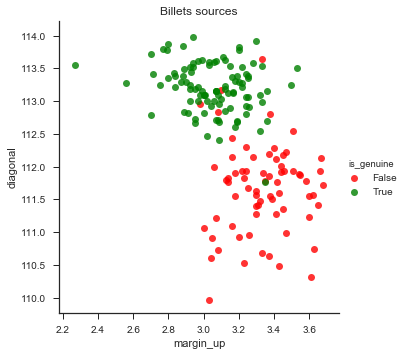

In [86]:
sns.lmplot( x='margin_up', y='diagonal', data=data, fit_reg=False, hue='is_genuine', palette=['r', 'g'])
plt.xlabel('margin_up')
plt.ylabel('diagonal')
plt.title('Billets sources')

plt.savefig('01 - Graphs/13 - Répartition billets sources.png', bbox_inches='tight', dpi=100)

plt.show()

In [87]:
test.reset_index(inplace=True)

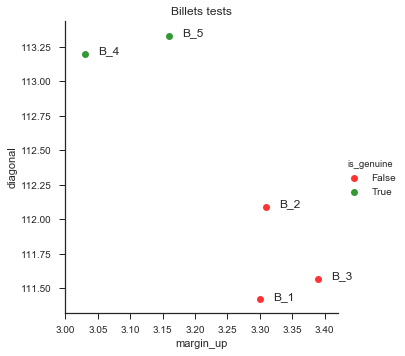

In [88]:
# Source 1: https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
# Source 2: Annoter avec Matplotlib : https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/

ax=sns.lmplot( x='margin_up', y='diagonal', data=test, fit_reg=False, hue='is_genuine', palette=['r', 'g'])


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(test.margin_up, test.diagonal, test.id, plt.gca())  

plt.xlabel('margin_up')
plt.ylabel('diagonal')
plt.title('Billets tests')

plt.savefig('01 - Graphs/14 - Répartition billets tests.png', bbox_inches='tight', dpi=100)   
    
plt.show()

Les billets tests se retrouvent bien dans les clusters vrai/faux du pool de billets source. Cela confirme les bonnes prédictions du modèle de regression logistique mis en place.

***
[Top de la page](#top)